GLM LINK FUNCTIONS FOR BERNOULLI/BINOMIAL MODELS

SCENARIO: Symmetric (Logit-friendly)

--------------------------------------------------------------------------------
Link Function: Logit
--------------------------------------------------------------------------------
Coefficients: [-0.43966768  0.85844222  0.2186869 ]
Log-Likelihood: -397.6554
AIC: 801.3109
BIC: -4532.3247
Deviance: 795.3109
Train Accuracy: 0.7650
Test Accuracy: 0.7550
Brier Score (test): 0.1601
MAE vs True Prob: 0.0173

--------------------------------------------------------------------------------
Link Function: Probit
--------------------------------------------------------------------------------
Coefficients: [-0.25639707  0.5091931   0.13011041]
Log-Likelihood: -397.4333
AIC: 800.8667
BIC: -4532.7689
Deviance: 794.8667
Train Accuracy: 0.7638
Test Accuracy: 0.7550
Brier Score (test): 0.1604
MAE vs True Prob: 0.0186

--------------------------------------------------------------------------------
Link Function:

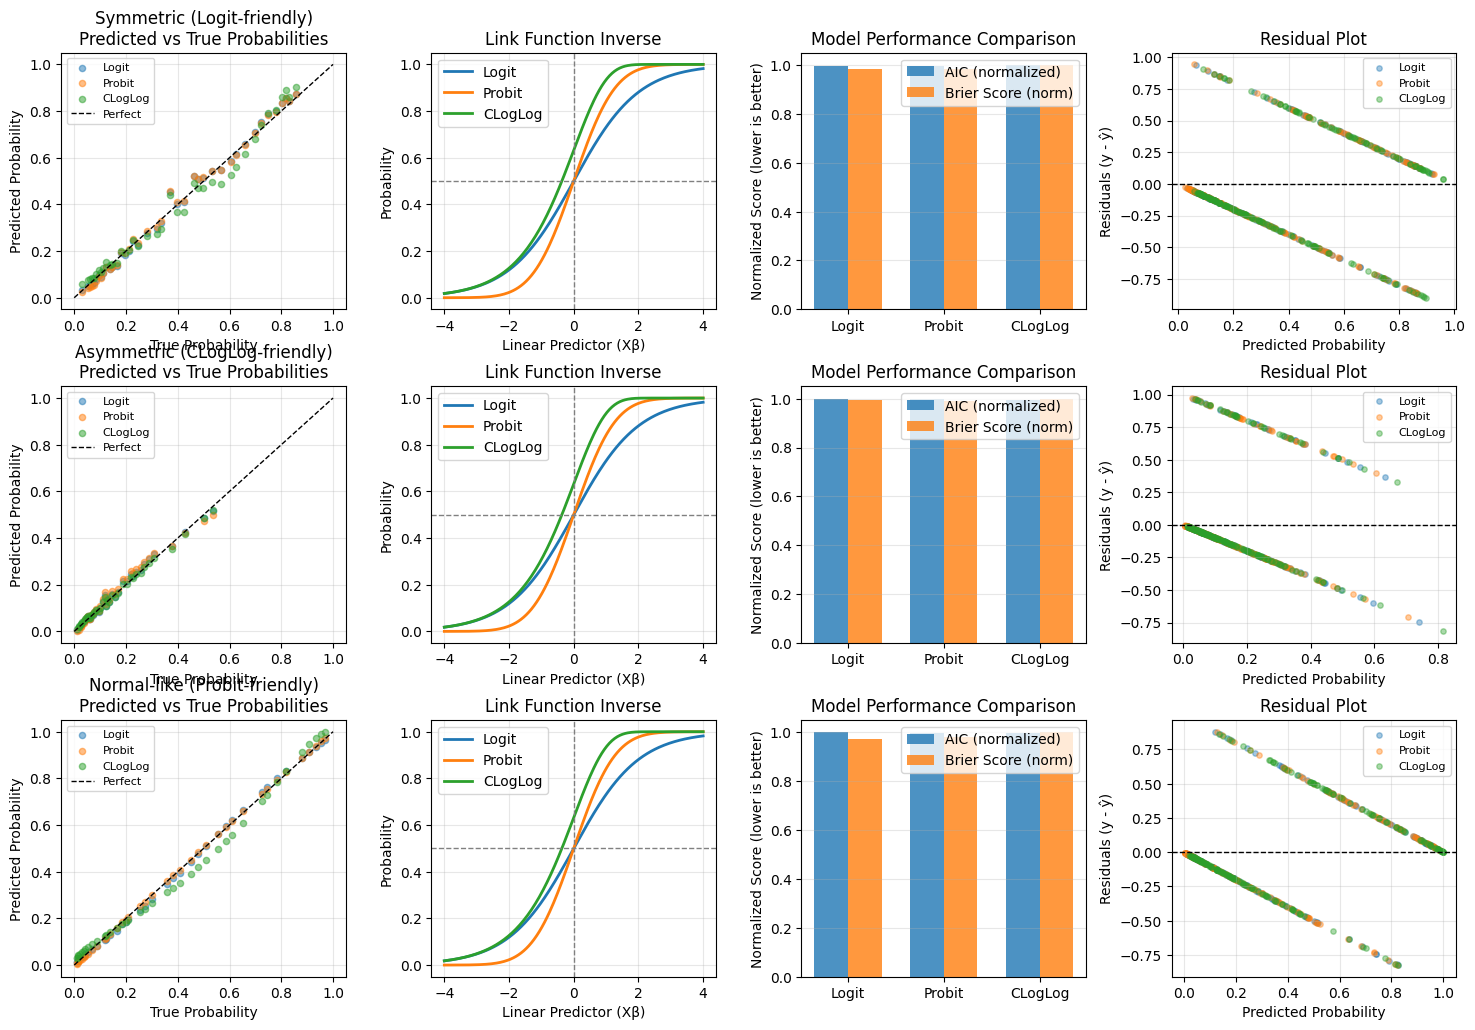


KEY INSIGHTS ABOUT LINK FUNCTIONS

1. LOGIT (Logistic) Link:
   • Most common for binary outcomes
   • Symmetric around 0.5 probability
   • Interpretation: Log-odds ratio
   • Best when: Relationship is symmetric
   
2. PROBIT (Normal CDF) Link:
   • Very similar to logit but slightly different tails
   • Based on standard normal distribution
   • Slightly more conservative in tails than logit
   • Best when: Data follows normal latent variable model
   
3. COMPLEMENTARY LOG-LOG Link:
   • Asymmetric relationship
   • Approaches 0 and 1 at different rates
   • Useful for rare events or grouped survival data
   • Best when: P(success) approaches 1 faster than it approaches 0

CHOOSING THE RIGHT LINK:
   ✓ Use AIC/BIC for model comparison
   ✓ Consider theoretical appropriateness
   ✓ Logit is default and usually works well
   ✓ CLogLog for asymmetric patterns or rare events
   ✓ Probit for latent variable interpretations
   
PRACTICAL NOTE:
   • Differences often small in practice
   

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import Logit, Probit, CLogLog, Log
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 80)
print("GLM LINK FUNCTIONS FOR BERNOULLI/BINOMIAL MODELS")
print("=" * 80)

# Generate synthetic data with different scenarios
def generate_data(n_samples=1000, scenario='symmetric'):
    """Generate data with different true underlying patterns"""
    X1 = np.random.uniform(-3, 3, n_samples)
    X2 = np.random.normal(0, 1, n_samples)
    
    if scenario == 'symmetric':
        # Symmetric relationship - ideal for logit
        linear_pred = -0.5 + 0.8 * X1 + 0.3 * X2
        prob = expit(linear_pred)  # Logistic function
        
    elif scenario == 'asymmetric':
        # Asymmetric relationship - better for complementary log-log
        linear_pred = -2 + 0.6 * X1 + 0.4 * X2
        prob = 1 - np.exp(-np.exp(linear_pred))  # CLogLog inverse
        
    elif scenario == 'normal':
        # Normal-like relationship - ideal for probit
        linear_pred = -0.3 + 0.7 * X1 + 0.25 * X2
        from scipy.stats import norm
        prob = norm.cdf(linear_pred)
    
    # Clip probabilities to avoid edge cases
    prob = np.clip(prob, 0.01, 0.99)
    
    # Generate binary outcomes
    y = np.random.binomial(1, prob)
    
    return X1, X2, y, prob

# Create three datasets with different characteristics
scenarios = {
    'symmetric': 'Symmetric (Logit-friendly)',
    'asymmetric': 'Asymmetric (CLogLog-friendly)', 
    'normal': 'Normal-like (Probit-friendly)'
}

# Define link functions to compare
link_functions = {
    'Logit': Logit(),
    'Probit': Probit(),
    'CLogLog': CLogLog(),
}

# Store results
all_results = {}

for scenario_name, scenario_desc in scenarios.items():
    print(f"\n{'=' * 80}")
    print(f"SCENARIO: {scenario_desc}")
    print(f"{'=' * 80}")
    
    # Generate data
    X1, X2, y, true_prob = generate_data(n_samples=1000, scenario=scenario_name)
    
    # Create design matrix
    X = np.column_stack([X1, X2])
    X = sm.add_constant(X)
    
    # Split into train and test
    train_idx = int(0.8 * len(y))
    X_train, X_test = X[:train_idx], X[train_idx:]
    y_train, y_test = y[:train_idx], y[train_idx:]
    true_prob_test = true_prob[train_idx:]
    
    scenario_results = {}
    
    # Fit models with different link functions
    for link_name, link_func in link_functions.items():
        print(f"\n{'-' * 80}")
        print(f"Link Function: {link_name}")
        print(f"{'-' * 80}")
        
        # Fit GLM
        model = sm.GLM(y_train, X_train, 
                      family=Binomial(link=link_func))
        result = model.fit()
        
        # Predictions
        pred_prob_train = result.predict(X_train)
        pred_prob_test = result.predict(X_test)
        
        # Calculate metrics
        # 1. Log-likelihood
        log_likelihood = result.llf
        
        # 2. AIC and BIC
        aic = result.aic
        bic = result.bic
        
        # 3. Deviance
        deviance = result.deviance
        
        # 4. Accuracy (using 0.5 threshold)
        pred_class_train = (pred_prob_train > 0.5).astype(int)
        pred_class_test = (pred_prob_test > 0.5).astype(int)
        accuracy_train = np.mean(pred_class_train == y_train)
        accuracy_test = np.mean(pred_class_test == y_test)
        
        # 5. Brier Score (mean squared error of probabilities)
        brier_train = np.mean((pred_prob_train - y_train) ** 2)
        brier_test = np.mean((pred_prob_test - y_test) ** 2)
        
        # 6. Mean absolute error vs true probabilities (test set)
        mae_true_prob = np.mean(np.abs(pred_prob_test - true_prob_test))
        
        # Store results
        scenario_results[link_name] = {
            'result': result,
            'aic': aic,
            'bic': bic,
            'deviance': deviance,
            'log_likelihood': log_likelihood,
            'accuracy_train': accuracy_train,
            'accuracy_test': accuracy_test,
            'brier_train': brier_train,
            'brier_test': brier_test,
            'mae_true_prob': mae_true_prob,
            'pred_prob_test': pred_prob_test,
            'coefficients': result.params
        }
        
        # Print summary
        print(f"Coefficients: {result.params}")
        print(f"Log-Likelihood: {log_likelihood:.4f}")
        print(f"AIC: {aic:.4f}")
        print(f"BIC: {bic:.4f}")
        print(f"Deviance: {deviance:.4f}")
        print(f"Train Accuracy: {accuracy_train:.4f}")
        print(f"Test Accuracy: {accuracy_test:.4f}")
        print(f"Brier Score (test): {brier_test:.4f}")
        print(f"MAE vs True Prob: {mae_true_prob:.4f}")
    
    # Print comparison
    print(f"\n{'=' * 80}")
    print("MODEL COMPARISON")
    print(f"{'=' * 80}")
    
    comparison_df = pd.DataFrame({
        'Link': link_functions.keys(),
        'AIC': [scenario_results[link]['aic'] for link in link_functions.keys()],
        'BIC': [scenario_results[link]['bic'] for link in link_functions.keys()],
        'Test Accuracy': [scenario_results[link]['accuracy_test'] for link in link_functions.keys()],
        'Brier Score': [scenario_results[link]['brier_test'] for link in link_functions.keys()],
        'MAE True Prob': [scenario_results[link]['mae_true_prob'] for link in link_functions.keys()]
    })
    
    print(comparison_df.to_string(index=False))
    
    # Identify best model
    best_aic = comparison_df.loc[comparison_df['AIC'].idxmin(), 'Link']
    best_brier = comparison_df.loc[comparison_df['Brier Score'].idxmin(), 'Link']
    best_mae = comparison_df.loc[comparison_df['MAE True Prob'].idxmin(), 'Link']
    
    print(f"\nBest by AIC: {best_aic}")
    print(f"Best by Brier Score: {best_brier}")
    print(f"Best by MAE (vs True Prob): {best_mae}")
    
    all_results[scenario_name] = {
        'results': scenario_results,
        'X_test': X_test,
        'y_test': y_test,
        'true_prob_test': true_prob_test,
        'comparison_df': comparison_df
    }

# Create comprehensive visualization
print(f"\n{'=' * 80}")
print("CREATING VISUALIZATIONS...")
print(f"{'=' * 80}")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

colors = {'Logit': '#1f77b4', 'Probit': '#ff7f0e', 'CLogLog': '#2ca02c'}

for row, (scenario_name, scenario_desc) in enumerate(scenarios.items()):
    results = all_results[scenario_name]['results']
    X_test = all_results[scenario_name]['X_test']
    y_test = all_results[scenario_name]['y_test']
    true_prob_test = all_results[scenario_name]['true_prob_test']
    
    # Plot 1: Predicted probabilities vs true probabilities
    ax1 = fig.add_subplot(gs[row, 0])
    for link_name in link_functions.keys():
        pred_prob = results[link_name]['pred_prob_test']
        # Sort for better visualization
        sorted_idx = np.argsort(true_prob_test)
        ax1.scatter(true_prob_test[sorted_idx][::5], pred_prob[sorted_idx][::5], 
                   alpha=0.5, s=20, label=link_name, color=colors[link_name])
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect')
    ax1.set_xlabel('True Probability')
    ax1.set_ylabel('Predicted Probability')
    ax1.set_title(f'{scenario_desc}\nPredicted vs True Probabilities')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Link function shapes
    ax2 = fig.add_subplot(gs[row, 1])
    linear_pred = np.linspace(-4, 4, 200)
    
    # Logit: expit(x) = 1 / (1 + exp(-x))
    logit_probs = expit(linear_pred)
    ax2.plot(linear_pred, logit_probs, label='Logit', 
            color=colors['Logit'], linewidth=2)
    
    # Probit: Φ(x)
    from scipy.stats import norm
    probit_probs = norm.cdf(linear_pred)
    ax2.plot(linear_pred, probit_probs, label='Probit', 
            color=colors['Probit'], linewidth=2)
    
    # CLogLog: 1 - exp(-exp(x))
    cloglog_probs = 1 - np.exp(-np.exp(linear_pred))
    ax2.plot(linear_pred, cloglog_probs, label='CLogLog', 
            color=colors['CLogLog'], linewidth=2)
    
    ax2.set_xlabel('Linear Predictor (Xβ)')
    ax2.set_ylabel('Probability')
    ax2.set_title('Link Function Inverse')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1)
    
    # Plot 3: Model performance metrics
    ax3 = fig.add_subplot(gs[row, 2])
    comparison_df = all_results[scenario_name]['comparison_df']
    
    x_pos = np.arange(len(link_functions))
    width = 0.35
    
    # Normalize metrics for comparison
    aic_norm = comparison_df['AIC'] / comparison_df['AIC'].max()
    brier_norm = comparison_df['Brier Score'] / comparison_df['Brier Score'].max()
    
    ax3.bar(x_pos - width/2, aic_norm, width, label='AIC (normalized)', alpha=0.8)
    ax3.bar(x_pos + width/2, brier_norm, width, label='Brier Score (norm)', alpha=0.8)
    ax3.set_ylabel('Normalized Score (lower is better)')
    ax3.set_title('Model Performance Comparison')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(comparison_df['Link'])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Residual analysis
    ax4 = fig.add_subplot(gs[row, 3])
    for link_name in link_functions.keys():
        pred_prob = results[link_name]['pred_prob_test']
        residuals = y_test - pred_prob
        linear_pred = np.log(pred_prob / (1 - pred_prob + 1e-10))  # Approximate
        ax4.scatter(pred_prob, residuals, alpha=0.4, s=15, 
                   label=link_name, color=colors[link_name])
    ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax4.set_xlabel('Predicted Probability')
    ax4.set_ylabel('Residuals (y - ŷ)')
    ax4.set_title('Residual Plot')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)

plt.savefig('glm_link_functions_comparison.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'glm_link_functions_comparison.png'")
plt.show()

# Summary insights
print(f"\n{'=' * 80}")
print("KEY INSIGHTS ABOUT LINK FUNCTIONS")
print(f"{'=' * 80}")
print("""
1. LOGIT (Logistic) Link:
   • Most common for binary outcomes
   • Symmetric around 0.5 probability
   • Interpretation: Log-odds ratio
   • Best when: Relationship is symmetric
   
2. PROBIT (Normal CDF) Link:
   • Very similar to logit but slightly different tails
   • Based on standard normal distribution
   • Slightly more conservative in tails than logit
   • Best when: Data follows normal latent variable model
   
3. COMPLEMENTARY LOG-LOG Link:
   • Asymmetric relationship
   • Approaches 0 and 1 at different rates
   • Useful for rare events or grouped survival data
   • Best when: P(success) approaches 1 faster than it approaches 0

CHOOSING THE RIGHT LINK:
   ✓ Use AIC/BIC for model comparison
   ✓ Consider theoretical appropriateness
   ✓ Logit is default and usually works well
   ✓ CLogLog for asymmetric patterns or rare events
   ✓ Probit for latent variable interpretations
   
PRACTICAL NOTE:
   • Differences often small in practice
   • Logit most interpretable (odds ratios)
   • Choose based on fit metrics AND theory
""")
print("=" * 80)